In [1]:
# !pip3 install --upgrade torch --user
# !pip3 install torchvision --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn


from torchvision import datasets
from torchvision import transforms

from utils.model_utils import PatchLoader
from utils.martemev_utils import compute_psnr, get_freer_gpu

from time import time

In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 8

GPU_NUM = 3

K_CLOSEST = 8
HIDDEN_SIZE = 32
PATCH_SIZE = (33, 33)

MODEL_NAME = 'CNN_full.33.valid'

In [3]:
train_dataloader = torch.utils.data.DataLoader(PatchLoader('../Data/train/clear/normed_crops.33.tensor', 
                                                           '../Data/train/noised/normed_crops.33.tensor'),
                                               batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

val_dataloader = torch.utils.data.DataLoader(PatchLoader('../Data/val/clear/normed_crops.33.tensor', 
                                                           '../Data/val/noised/normed_crops.33.tensor'),
                                               batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [4]:
class GraphConv(nn.Module):
    def __init__(self, k, input_channels, out_channels, search_area=None):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, 1)
        self.conv2 = nn.Conv2d(input_channels, out_channels, 3, padding=1)
        self.conv3 = nn.Conv2d(input_channels, out_channels, 5, padding=2)
        
    def forward(self, x):
        return torch.mean(torch.stack([self.conv1(x),
                                       self.conv2(x),
                                       self.conv3(x)]), dim=0) # here is conv instead of gc
    
    
class PreProcessBlock(nn.Module):
    def __init__(self, input_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, kernel_size,
                              padding=(kernel_size//2, kernel_size//2))
        self.activ = nn.LeakyReLU(0.05)
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.GC = GraphConv(k, out_channels, out_channels) # out_channels -> out_channels
        
    def forward(self, x):
        x = self.activ(self.conv(x))
        x = self.GC(x)
        x = self.activ(self.bn(x))
        return x
    
class Residual(nn.Module):
    def __init__(self, k, input_channels, out_channels):
        super().__init__()
        self.pipeline = nn.Sequential(
            GraphConv(k, input_channels, input_channels),
            nn.BatchNorm2d(input_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, input_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
        )
        
    def forward(self, x):
        return self.pipeline(x)
    
class PreProcessBlock(nn.Module):
    def __init__(self, k, kernel_size, input_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, kernel_size,
                              padding=(kernel_size//2, kernel_size//2))
        self.activ = nn.LeakyReLU(0.05)
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.GC = GraphConv(k, out_channels, out_channels) # out_channels -> out_channels
        
    def forward(self, x):
        x = self.activ(self.conv(x))
        x = self.GC(x)
        x = self.activ(self.bn(x))
        return x

In [5]:
loss_mse = nn.MSELoss()

class CNN(nn.Module):
    def __init__(self, k, input_channels, hidden_channels, patch_size=(64, 64)):
        super().__init__()
        self.patch_size = patch_size
        self.preprocessing_blocks = nn.ModuleList([
            PreProcessBlock(k, 3, input_channels, hidden_channels),
            PreProcessBlock(k, 5, input_channels, hidden_channels),
            PreProcessBlock(k, 7, input_channels, hidden_channels),
        ])
        self.residual_1 = Residual(k, hidden_channels*3, hidden_channels)
        self.residual_2 = Residual(k, hidden_channels, hidden_channels)
        
        self.GC = GraphConv(k, hidden_channels, input_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(hidden_channels*3, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
            nn.Conv2d(hidden_channels, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
        )
        
    def fit_image(self, image):
        processed_image = torch.cat([block(image) for block in self.preprocessing_blocks], dim=1)
        residual_1 = self.residual_1(processed_image)
        result_1 = residual_1 + self.downsample(processed_image)
        residual_2 = self.residual_2(result_1)
        result = residual_2 + result_1
        return [processed_image, residual_1, result, self.GC(result)]
    
    def forward(self, clear_image, noised_image):
        processed_image, residual_1, residual_2, answer = self.fit_image(clear_image)
        n_processed_image, n_residual_1, n_residual_2, n_answer = self.fit_image(noised_image)
        perceptual_loss = loss_mse(processed_image, n_processed_image) + \
            loss_mse(residual_1, n_residual_1) + \
            loss_mse(residual_2, n_residual_2)
        return n_answer, perceptual_loss
    
    def forward_eval(self, noised_image):
        _, _, _, answer = self.fit_image(noised_image)
        return answer

    
    def forward_image(self, noised_image, device, chunks=16):
        p_x, p_y = self.patch_size
        splits = torch.split(torch.stack(torch.split(noised_image, p_x)), p_y, dim=2)
        crops = torch.stack(splits, dim=2)        
        crops = crops.view(-1, 1, p_x, p_y)
        crops_ = torch.split(crops, crops.shape[0]//chunks, dim=0)
        answer = torch.cat([crop + self.forward_eval(crop.cuda(device)).cpu().data for crop in crops_], dim=0)
        a_x, a_y = noised_image.shape
        return torch.clamp(answer, 0, 1).view(a_x, a_y)


In [6]:
gpu_num = get_freer_gpu()
device = torch.device('cuda:{}'.format(GPU_NUM))
device

device(type='cuda', index=3)

In [7]:
model = CNN(K_CLOSEST, 1, HIDDEN_SIZE, patch_size=PATCH_SIZE).cuda(device)
optim = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lambda x: 0.97**x)

In [8]:
from tensorboardX import SummaryWriter
import torchvision.utils as vutils


writer = SummaryWriter('./TensorBoard/{}'.format(MODEL_NAME))

In [9]:
val_images_clear =  torch.load('../Data/val/clear/normalized_data.tensor')
val_images_noised =  torch.load('../Data/val/noised/normalized_data.tensor')

In [10]:
for epoch in tqdm.tqdm_notebook(range(100)):
    for train_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(train_dataloader, desc='Train loop', leave=False)):
        model.train()
        ind = epoch * len(train_dataloader) + train_ind
        optim.zero_grad()
        image, noise_image = image.cuda(device), noise_image.cuda(device)
        start_time = time()
        denoised_diff, perceptual_loss = model(image, noise_image)
        end_time = time() - start_time
        writer.add_scalar('train/iteration_time', end_time, ind)
        writer.add_scalar('train/perceptual_loss', perceptual_loss.item(), ind)
        denoise_image = denoised_diff + noise_image
        loss = loss_mse(image, denoise_image)
        writer.add_scalar('train/mse_loss', loss.item(), ind)
        loss = loss + perceptual_loss
        loss.backward()
        optim.step()
        writer.add_scalar('train/psnr', compute_psnr(image, denoise_image), ind)
    scheduler.step()
    model.eval()
    losses, psnrs = [], []
    for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(val_dataloader, desc='Test loop', leave=False)):
        image, noise_image = image.cuda(device), noise_image.cuda(device)
        denoised_diff, perceptual_loss = model(image, noise_image)
        denoise_image = denoised_diff + noise_image
        loss = loss_mse(image, denoise_image)
        loss = loss + perceptual_loss
        losses.append(loss.item())
        psnrs.append(compute_psnr(image, denoise_image))
    writer.add_scalar('val/psnr', np.mean(psnrs), ind)
    writer.add_scalar('val/combined_loss', np.mean(losses), ind)
    img_indexes = torch.randint(high=len(noise_image), size=(10,))
    dummy_img = torch.cat([image[img_indexes],
                           noise_image[img_indexes],
                           denoise_image[img_indexes]], dim=0).cpu().data
    x = vutils.make_grid(dummy_img, nrow=10)
    writer.add_image('val/crops', x, ind)

    img_index = torch.randint(high=len(val_images_clear), size=(1,))
    clear_image = val_images_clear[img_index]
    noised_image = val_images_noised[img_index]
    start_time = time()
    denoised_image = model.forward_image(noised_image.squeeze(0), device).cpu().data.unsqueeze(0)
    end_time = time() - start_time
    writer.add_scalar('val/full_image_time', end_time, ind)
    d_x, d_y = denoised_image.shape[-2:]
    writer.add_image('val/clear_image', clear_image[:, :d_x, :d_y], ind)
    writer.add_image('val/noised_image', noised_image[:, :d_x, :d_y], ind)
    writer.add_image('val/denoised_image', denoised_image[:, :d_x, :d_y], ind)            
            
            

In [11]:
torch.save(model, 'SavedModels/{}.model'.format(MODEL_NAME))
torch.save(model.state_dict(), 'SavedModels/{}.state_dict'.format(MODEL_NAME))


/afs/cern.ch/user/m/martemev/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/afs/cern.ch/user/m/martemev/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PreProcessBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/afs/cern.ch/user/m/martemev/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GraphConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/afs/cern.ch/user/m/martemev/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Residual. It won't be checked for

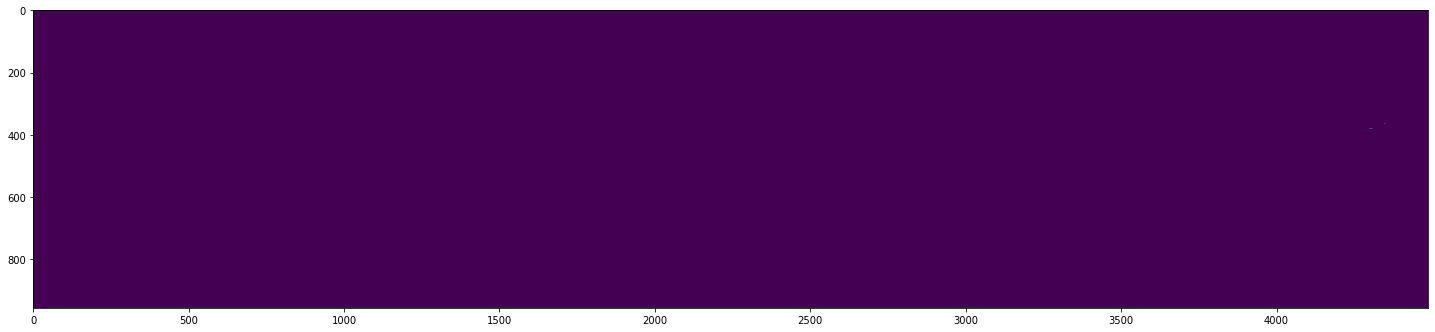

In [12]:
plt.figure(figsize=(25, 15))

plt.imshow(clear_image.squeeze(0))
plt.show()

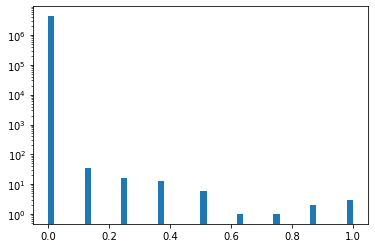

In [13]:
plt.hist(clear_image.view(-1), bins=50)
plt.yscale('log')
plt.show()

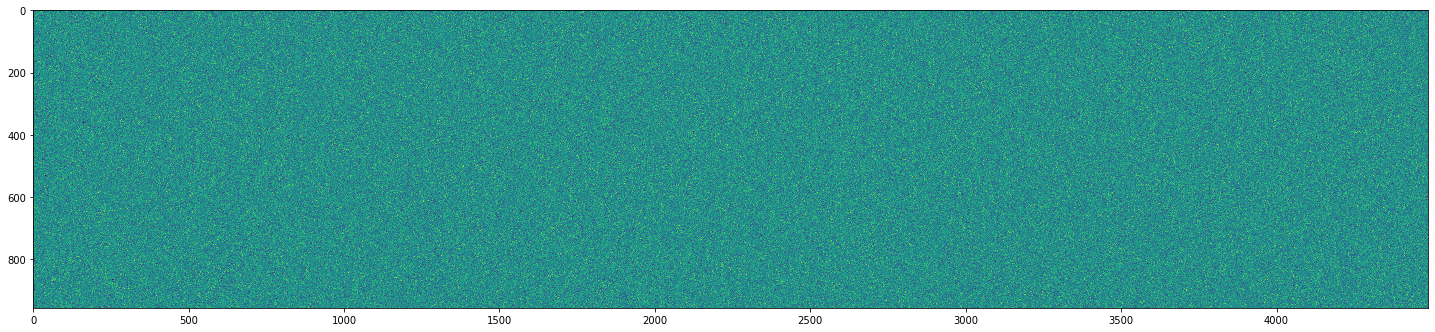

In [14]:
plt.figure(figsize=(25, 15))

plt.imshow(noised_image.squeeze(0))
plt.show()

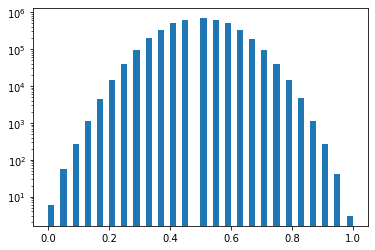

In [15]:
plt.hist(noised_image.view(-1), bins=50)
plt.yscale('log')
plt.show()

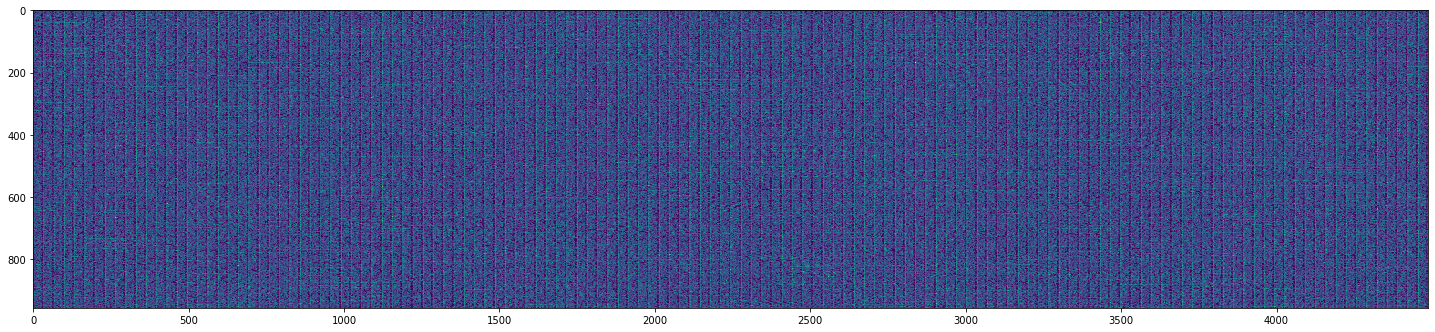

In [16]:
plt.figure(figsize=(25, 15))

plt.imshow(denoised_image.squeeze(0))
plt.show()

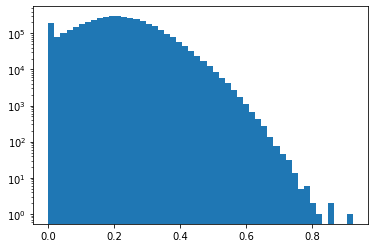

In [17]:
plt.hist(denoised_image.view(-1), bins=50)
plt.yscale('log')
plt.show()

In [18]:
clear_image.mean()

tensor(5.1804e-06)

In [19]:
denoised_image.mean()

tensor(0.2064)

In [20]:
for epoch in tqdm.tqdm_notebook(range(100)):
    for train_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(train_dataloader, desc='Train loop', leave=False)):
        model.train()
        ind = epoch * len(train_dataloader) + train_ind
        optim.zero_grad()
        image, noise_image = image.cuda(device), noise_image.cuda(device)
        start_time = time()
        denoised_diff, perceptual_loss = model(image, noise_image)
        end_time = time() - start_time
        writer.add_scalar('train/iteration_time', end_time, ind)
        writer.add_scalar('train/perceptual_loss', perceptual_loss.item(), ind)
        denoise_image = denoised_diff + noise_image
        loss = loss_mse(image, denoise_image)
        writer.add_scalar('train/mse_loss', loss.item(), ind)
        loss = loss + perceptual_loss
        loss.backward()
        optim.step()
        writer.add_scalar('train/psnr', compute_psnr(image, denoise_image), ind)
    scheduler.step()
    model.eval()
    losses, psnrs = [], []
    for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(val_dataloader, desc='Test loop', leave=False)):
        image, noise_image = image.cuda(device), noise_image.cuda(device)
        denoised_diff, perceptual_loss = model(image, noise_image)
        denoise_image = denoised_diff + noise_image
        loss = loss_mse(image, denoise_image)
        loss = loss + perceptual_loss
        losses.append(loss.item())
        psnrs.append(compute_psnr(image, denoise_image))
    writer.add_scalar('val/psnr', np.mean(psnrs), ind)
    writer.add_scalar('val/combined_loss', np.mean(losses), ind)
    img_indexes = torch.randint(high=len(noise_image), size=(10,))
    dummy_img = torch.cat([image[img_indexes],
                           noise_image[img_indexes],
                           denoise_image[img_indexes]], dim=0).cpu().data
    x = vutils.make_grid(dummy_img, nrow=10)
    writer.add_image('val/crops', x, ind)

    img_index = torch.randint(high=len(val_images_clear), size=(1,))
    clear_image = val_images_clear[img_index]
    noised_image = val_images_noised[img_index]
    start_time = time()
    denoised_image = model.forward_image(noised_image.squeeze(0), device).cpu().data.unsqueeze(0)
    end_time = time() - start_time
    writer.add_scalar('val/full_image_time', end_time, ind)
    d_x, d_y = denoised_image.shape[-2:]
    writer.add_image('val/clear_image', clear_image[:, :d_x, :d_y], ind)
    writer.add_image('val/noised_image', noised_image[:, :d_x, :d_y], ind)
    writer.add_image('val/denoised_image', denoised_image[:, :d_x, :d_y], ind)            
            
            

In [21]:
torch.save(model, 'SavedModels/{}.model'.format(MODEL_NAME))
torch.save(model.state_dict(), 'SavedModels/{}.state_dict'.format(MODEL_NAME))


In [48]:
torch.randint(high=len(val_images_clear), size=(1,))

tensor([18])

In [56]:
def plot_comparison(img_index=None):
    if not img_index:
        img_index = torch.randint(high=len(val_images_clear), size=(1,))
    else:
        img_index = torch.Tensor([img_index]).long()
        
        
    clear_image = val_images_clear[img_index]
    noised_image = val_images_noised[img_index]
    start_time = time()
    denoised_image = model.forward_image(noised_image.squeeze(0), device).cpu().data.unsqueeze(0)

    plt.figure(figsize=(35, 15))
    for ind, (im, name) in enumerate(zip([clear_image, noised_image, denoised_image], ['clear', 'noised', 'denoised'])):
        plt.subplot(3, 1, ind+1)
        plt.imshow(im.squeeze(0)) # [200:500, 1600:2200]
        plt.title(name)
    plt.show()    
    
    plt.figure(figsize=(35, 15))
    for ind, (im, name) in enumerate(zip([clear_image, noised_image, denoised_image], ['clear', 'noised', 'denoised'])):
        plt.subplot(3, 1, ind+1)
        plt.hist(im.view(-1), bins=50)
        plt.yscale('log')
        plt.title(name)
    plt.show()    
    
    return img_index
    

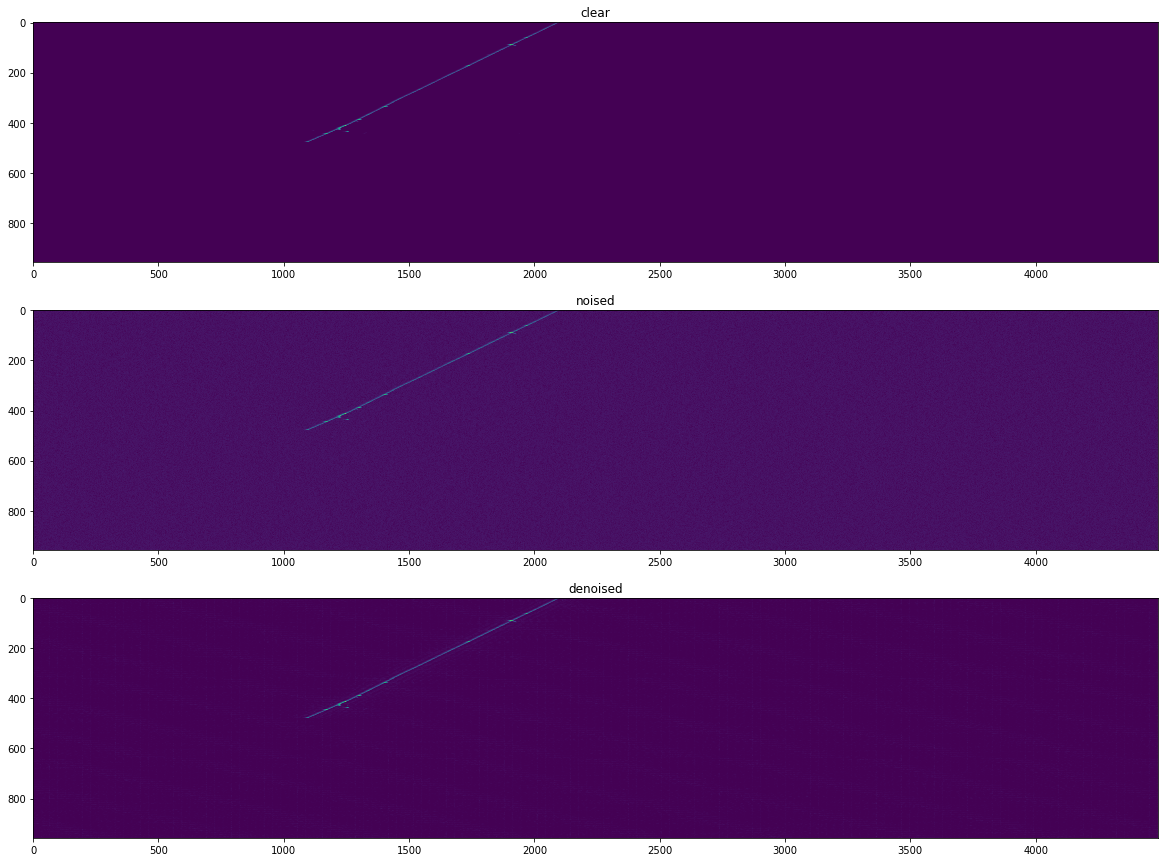

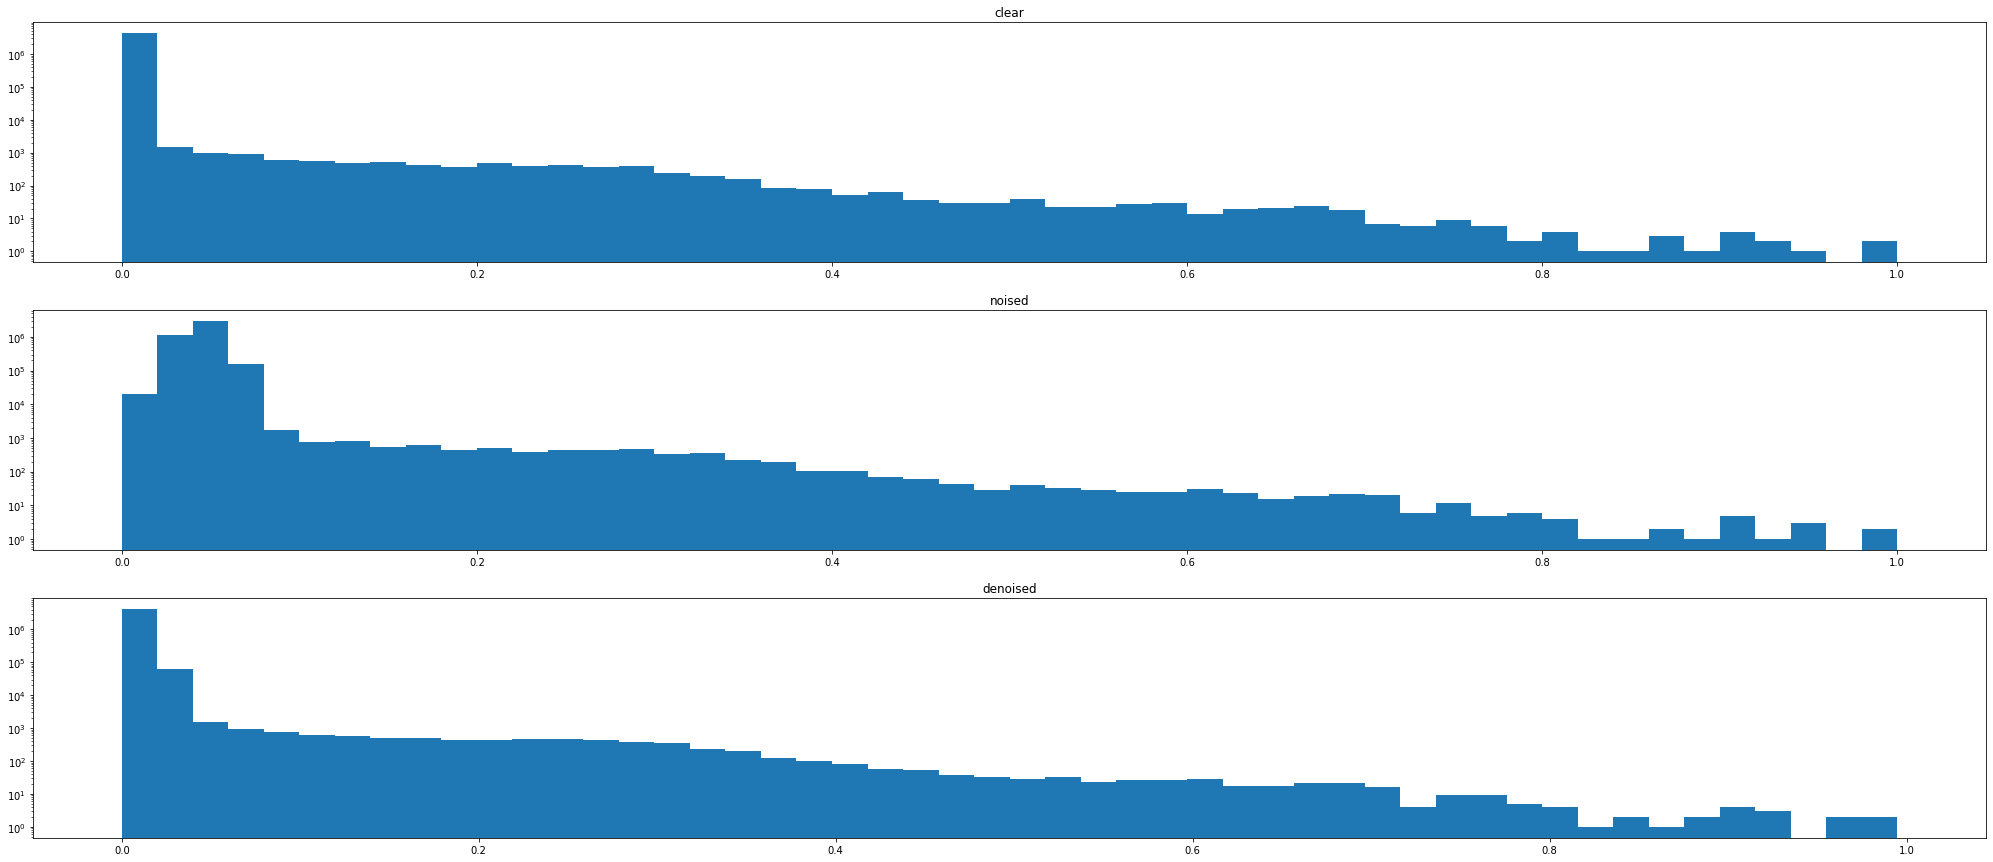

tensor([9])

In [59]:
plot_comparison(img_index=0)